In [34]:
import os
import random
from PIL import Image

real_image_dir = "./real_vs_fake_dataset/0_real"
fake_image_dir = "./real_vs_fake_dataset/1_fake"

In [35]:
def load_images(image_dir):
    image_paths = [
        os.path.join(image_dir, img) for img in os.listdir(image_dir)
        if img.endswith(('.png', '.jpg', '.jpeg'))
    ]
    images = [Image.open(path).convert('RGB') for path in image_paths]
    return images

real_images = load_images(real_image_dir)
fake_images = load_images(fake_image_dir)

In [36]:
import matplotlib.pyplot as plt

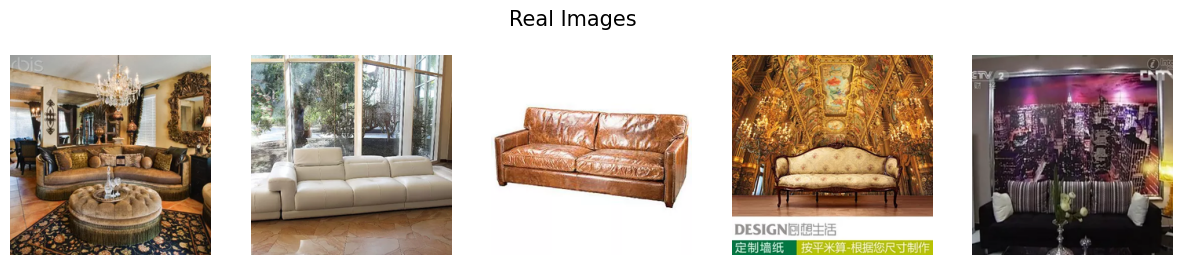

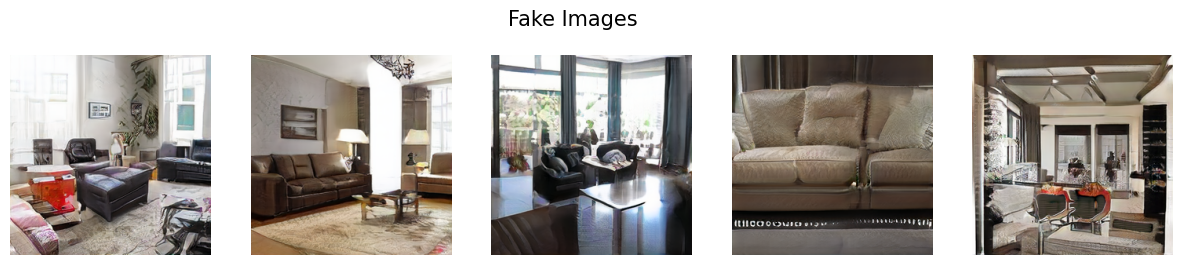

In [37]:
def visualize_images(images, title, num_images=5):
    plt.figure(figsize=(15, 3))
    for i, img in enumerate(images[:num_images]):
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title, fontsize=15)
    plt.show()

visualize_images(real_images, "Real Images")
visualize_images(fake_images, "Fake Images")

In [38]:
from transformers import CLIPProcessor
from transformers import CLIPModel 
import torch
import tqdm
import numpy as np

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 7695.97it/s]


In [40]:
def extract_features(images, model, processor):
    features = []
    for img in tqdm.tqdm(images, desc="Extracting features"):
        inputs = processor(images=img, return_tensors="pt").to(device)
        with torch.no_grad():
            feature = model.get_image_features(**inputs)
        features.append(feature.cpu().numpy().flatten())
    return np.array(features)

In [41]:
real_features = extract_features(real_images, model, processor)
fake_features = extract_features(real_images, model, processor)

Extracting features: 100%|██████████| 100/100 [00:05<00:00, 17.14it/s]


In [42]:
from sklearn.manifold import TSNE

In [43]:
features = np.vstack((real_features, fake_features))
labels = np.array([0] * len(real_features) + [1] * len(fake_features))

tsne = TSNE(n_components=2, perplexity=50, random_state=42)
tsne_results = tsne.fit_transform(features)

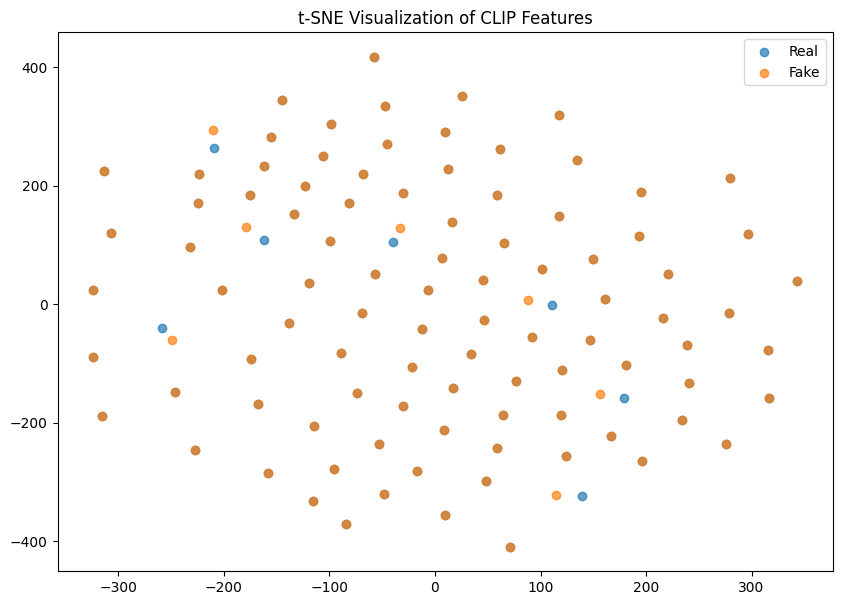

In [45]:
def plot_tsne(tsne_results, labels):
    plt.figure(figsize=(10,7))
    plt.scatter(tsne_results[labels == 0, 0],
                tsne_results[labels == 0, 1],
                label="Real", alpha=0.7)
    plt.scatter(tsne_results[labels == 1, 0],
                tsne_results[labels == 1, 1],
                label="Fake", alpha=0.7)
    plt.legend()
    plt.title("t-SNE Visualization of CLIP Features")
    plt.show()

plot_tsne(tsne_results, labels)

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

In [ ]:
real_labels = np.zeros(len(real_features))
fake_labels = np.ones(len(fake_features))

x = np.vstack((real_features, fake_features))
y = np.concatenate((real_labels, fake_labels))

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [51]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [52]:
y_pred = knn.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'모델 정확도: {accuracy:.2f}')

모델 정확도: 0.17


In [53]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [55]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 3 18]
 [15  4]]


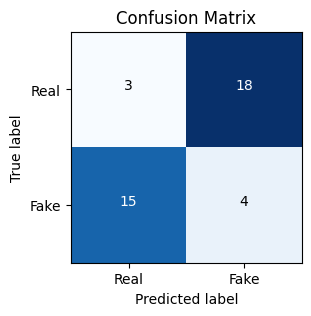

In [56]:
plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Real', 'Fake'])
plt.yticks(tick_marks, ['Real', 'Fake'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.grid(False)
for i, j in np.ndindex(cm.shape):
    plt.text(j,i,cm[i,j],
             horizontalalignment='center',
             color='white' if cm[i,j] > cm.max() / 2 else 'black')

In [ ]:
## 탐구하기
객관식 = {
    '1번 문제' : '2번[딥러닝과 가짜(Fake)의 합성어로 존재하지 않는 것을 존재하는것 처럼 보이도록 속이는 기술을 말한다]',
    '2번 문제' : '1번[생성자와 판별자가 서로 경쟁하는 구도이다]',
    '3번 문제' : '1번[음성인식 프로그램 우회 프로그램 개발]',
    '4번 문제' : '3번[이미지와 텍스트를 함께 이해할 수 있다]'
}
주관식_5번 = """
딥러닝이란 인간의 뉴런을 모방한 인공 신경망을 기반으로 한 머신러닝 기술입니다.
입력층과 출력층 사이에 여러 은닉층을 가지고 두껍게 만들어서 많은 데이터를 잘 학습할 수 있습니다.
층을 늘릴수록 더 큰 데이터(빅데이터)를 학습하여 더 높은 성능을 낼 수 있습니다.
자연어 처리(chat GPT, gemini, exaone, gemma, gpt oss, llama 등...), 음성 인식과 자율주행, 마지막으로 컴퓨터 비전까지 많은 분야에서 사용됩니다.
"""
주관식_6번 = """
예 또는 아니오, 가짜 또는 진짜 이미지 같이 두 가지의 묶음 중에서 하나로 구분하는 것.
로지스틱 회귀를 사용하면 -> 0.5 미만이면 보통 0으로 분류되고, 0.5이상이면 보통 1로 분류됨.
스팸 메일 같은 거를 분류(스팸과 습햄(?))할 때도 쓰이고 위와 같이 가짜 이미지인지 진짜 이미지인지 구분할때도 쓰인다.
"""
주관식_7번 ="""
우리가 설정한 개수만큼의 가장 가까운 이웃의 묶음 번호를 확인하고 그중에서 가장 많은 것을 고른다.
"""
주관식_8번 ="""
한쌍의 이미지-문장을 같이 보며 같은 뜻이면 가깝게, 다르면 멀게 하라는 규칙을 가지고 학습한 멀티모달 표현 학습 모델이라고 한다.
이미지와 텍스트를 상호 검색 가능하다. GPT가 그러는데
## CLIP + GPT, 어디에 새롭게 쓸 수 있을까?

1. **패션 매칭 AI 거울**
   * CLIP은 “옷 사진”과 “스타일 설명”을 연결할 수 있어.
   * 거울 앞에서 옷을 찍으면 → CLIP이 “이건 스트릿 패션, 캐주얼” 같은 특징을 찾아냄.
   * GPT는 그 결과를 바탕으로 “이 옷은 흰 운동화랑 잘 어울려요” 같은 자연스러운 추천 문장을 만들어줌.
   * 기존 쇼핑몰 필터보다 훨씬 개인화된 **패션 코디 조언 시스템**이 될 수 있음.

2. **여행 AR 가이드**
   * 여행지에서 건물이나 유적을 카메라로 찍으면 → CLIP이 비슷한 이미지를 찾아냄.
   * GPT가 “이 건물은 18세기에 지어진 성당이며, 뒷면에는 작은 정원이 있습니다”처럼 역사/스토리 설명을 자연스럽게 이어줌.
   * 지금의 네이버 지도/구글 지도보다 한 단계 발전한 **실시간 문화 해설 도우미** 가능.

3. **학습용 그림책 보조교사**
   * 아이가 그림을 그려서 보여주면 → CLIP이 “고양이, 집, 나무” 등을 인식.
   * GPT가 그 그림을 바탕으로 “옛날에 한 마을에 고양이와 아이가 살았어요…”라는 맞춤형 이야기를 지어줌.
   * 즉석에서 아이 그림을 **스토리텔링 학습 자료**로 바꿔주는 서비스.

4. **시각장애인 전용 소셜 네트워크**
   * 사용자가 사진을 올리면 CLIP이 내용을 뽑고, GPT가 그 사진을 따뜻한 말투로 설명.
   * “친구가 웃고 있는 사진이에요. 뒤에는 가을 단풍이 물들었네요.”
   * 지금까지의 단순 OCR이나 짧은 캡션보다 **감정과 맥락이 담긴 묘사**를 제공.

5. **직업 훈련 시뮬레이터**
   * 예: 의사가 수술 장면 이미지를 찍으면 CLIP이 상황 파악 → GPT가 “이 경우엔 봉합을 먼저 하고 출혈을 막는 것이 우선입니다”라고 훈련 피드백.
   * 실제 교육 시뮬레이터보다 훨씬 유연한 **직업별 현장 학습 도우미**로 발전 가능.

가 좋다고 한다. 다 좋은 것 같다. 특히 3번이 제일 마음에 든다.
"""
주관식_9번 = """
네! 제출하겠습니다.
"""